# Data Science Challenge

In [1150]:
# If you'd like to install packages that are not installed by default, uncomment the last two lines of this cell and replace <package list> with a list of your packages.
# This will ensure your notebook has all the dependencies and works everywhere
import sys
# !{sys.executable} -m pip install xgboost sklearn pandas numpy seaborn scipy matplotlib

In [1151]:
#Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import xgboost
from xgboost import XGBRegressor
pd.set_option("display.max_columns", 101)

## Data Description

Column | Description
:---|:---
`id` | Record index
`timestamp` | Datetime (YYYY:MM:DD HH:MM:SS)
`country` | Current country of employment
`employment_status` | Employment status (Full time, Part time, Independent or freelancer)
`job_title` | Current job title of the candidate
`job_years` | No. of years working on the job
`is_manager` | Whether the candidate holds a managerial position or not (Yes or No)
`hours_per_week` | No. of hours per day committed to the current job
`telecommute_days_per_week` | No. of telecommuting days per week (working from home)
`education` | Highest degree in education the candidate has received
`is_education_computer_related` | Is the education related to the field of computer science (Yes or No)
`certifications` | Does the candidate have any relevant certifications (Yes or No)
`salary` | Monthly Salary (in US $$)


## Data Wrangling & Visualization

In [1152]:
# Dataset is already loaded below
data = pd.read_csv("train.csv")

In [1153]:
data.head()

,id,timestamp,country,employment_status,job_title,job_years,is_manager,hours_per_week,telecommute_days_per_week,education,is_education_computer_related,certifications,salary
0,1,12/11/2018 10:52:26,Slovenia,Full time,Developer,4.78393,Yes,40.0,0.0,Bachelors (4 years),Yes,No,7187.743094
1,2,1/5/2017 16:57:50,United States,Full time,DBA,5.00000,No,40.0,5.0,Bachelors (4 years),Yes,No,10000.000000
2,3,12/18/2017 8:13:15,Sweden,Full time,DBA,1.00000,No,40.0,0.0,Masters,Yes,Yes,7000.000000
3,4,12/27/2018 4:56:52,United States,Full time,DBA,1.00000,No,40.0,2.0,Bachelors (4 years),No,No,8333.000000
4,5,12/11/2018 14:07:58,United States,Full time,Developer,3.00000,No,40.0,2.0,Masters,Yes,Yes,7137.000000


In [1154]:
#Explore columns
data.columns

Index(['id', 'timestamp', 'country', 'employment_status', 'job_title',
       'job_years', 'is_manager', 'hours_per_week',
       'telecommute_days_per_week', 'education',
       'is_education_computer_related', 'certifications', 'salary'],
      dtype='object')

In [1155]:
#Description
data.describe()

,id,job_years,hours_per_week,telecommute_days_per_week,salary
count,4277.00000,4277.000000,4260.000000,4266.000000,4277.000000
mean,2139.00000,4.479697,40.859110,1.034927,7057.701984
std,1234.80788,1.990783,1.754911,1.651160,1308.572568
min,1.00000,0.000000,37.000000,0.000000,3622.000000
25%,1070.00000,3.407156,40.000000,0.000000,6496.788236
50%,2139.00000,4.640830,40.000000,0.000000,7166.000000
75%,3208.00000,5.000000,41.114138,1.000000,7614.831964
max,4277.00000,10.000000,45.000000,5.000000,10625.000000


Let's remove Timestamp and instead add year variables

In [1156]:
data['year']=pd.DatetimeIndex(data['timestamp']).year
data=data.drop(columns=['timestamp'])
data.columns

Index(['id', 'country', 'employment_status', 'job_title', 'job_years',
       'is_manager', 'hours_per_week', 'telecommute_days_per_week',
       'education', 'is_education_computer_related', 'certifications',
       'salary', 'year'],
      dtype='object')

categorical variables value frequencies

In [1157]:
data['is_manager'].value_counts()

No     3293
Yes     984
Name: is_manager, dtype: int64

In [1158]:
data['is_education_computer_related'].value_counts()

Yes        2425
No         1193
Unknown     643
Name: is_education_computer_related, dtype: int64

In [1159]:
data['certifications'].value_counts()

Yes    2185
No     2092
Name: certifications, dtype: int64

In [1160]:
data['employment_status'].value_counts()

Full time                                     4088
Independent or freelancer or company owner     170
Part time                                       19
Name: employment_status, dtype: int64

Let's drop nan values from data

In [1161]:
data=data.dropna()

Visualisation

In [1162]:
# plot definitions
def hist_plot(var):
    plt.hist(data[var],50,density=True,facecolor='g', alpha=0.75, histtype='bar', ec='black')
    plt.title('Histogram of '+var)
    plt.ylabel('Probability',fontsize=12)
    plt.xlabel(var,fontsize=12)
    current_values = plt.gca().get_xticks()
    plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
    plt.grid(True, color = "grey", linewidth = "0.2", linestyle = "-.")
    plt.show()
    
def hist_plot_rot(var):
    plt.hist(data[var],50,density=True,facecolor='g', alpha=0.75, histtype='bar', ec='black')
    plt.title('Histogram of '+var)
    plt.ylabel('Probability',fontsize=12)
    plt.xlabel(var,fontsize=12)
    current_values = plt.gca().get_xticks()
    plt.gca().set_xticklabels(['{:,.0f}'.format(x) for x in current_values])
    plt.grid(True, color = "grey", linewidth = "0.2", linestyle = "-.")
    plt.xticks(rotation=45)
    plt.show()
    
def hist_plot_perc(var):
    n, bin_edges = np.histogram(data[var], 100)
    # Normalize it, so that every bins value gives the probability of that bin
    bin_probability = n/float(n.sum())
    # Get the mid points of every bin
    bin_middles = (bin_edges[1:]+bin_edges[:-1])/2.
    # Compute the bin-width
    bin_width = bin_edges[1]-bin_edges[0]
    # Plot the histogram as a bar plot
    plt.bar(bin_middles, bin_probability, width=bin_width, ec='black')
    plt.title('Histogram of '+var)
    plt.ylabel('Probability',fontsize=12)
    plt.xlabel(var,fontsize=12)
    current_values = plt.gca().get_xticks()
    plt.gca().set_xticklabels(['{:,.2f}'.format(x) for x in current_values])
    plt.grid(True, color = "grey", linewidth = "0.2", linestyle = "-.")
    plt.show()
    
def freq_plot(var):
    if data[var].dtype==float:
        country_count = data[var].value_counts()
        country_count.index=country_count.index.astype(int)
    elif data[var].dtype!="O" and data[var].dtype=='int64':
        country_count = data[var].value_counts()
    else:
        country_count = data[var].fillna('Missing').value_counts(dropna=False)
    sns.set(style="darkgrid")
    sns.barplot(country_count.index[0:20],country_count.values[0:20],alpha=0.9)
    plt.title('Frequency Distribution of '+var)
    plt.ylabel('Number of Occurrences',fontsize=12)
    plt.xlabel(var,fontsize=12)
    plt.show()
    
def freq_plot_rot(var):
    if data[var].dtype==float:
        country_count = data[var].value_counts()
        country_count.index=country_count.index.astype(int)
    else:
        country_count = data[var].fillna('Missing').value_counts(dropna=False)
    sns.set(style="darkgrid")
    sns.barplot(country_count.index[0:20],country_count.values[0:20],alpha=0.9)
    plt.title('Frequency Distribution of '+var)
    plt.ylabel('Number of Occurrences',fontsize=12)
    plt.xlabel(var,fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

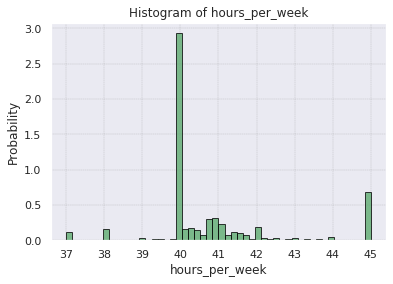

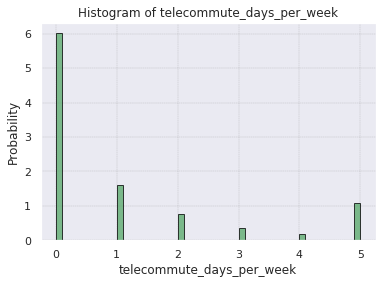

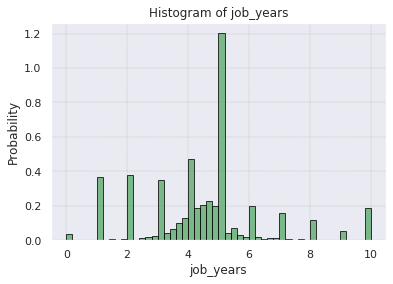

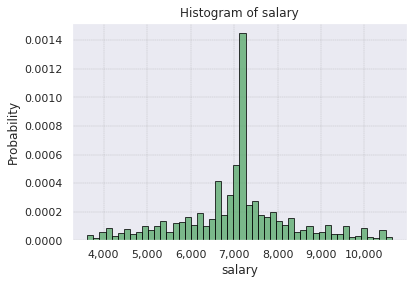

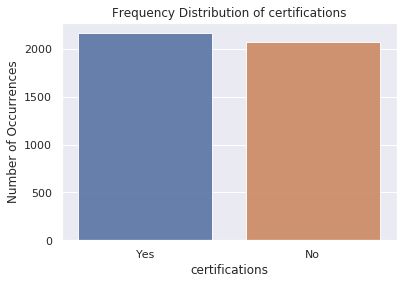

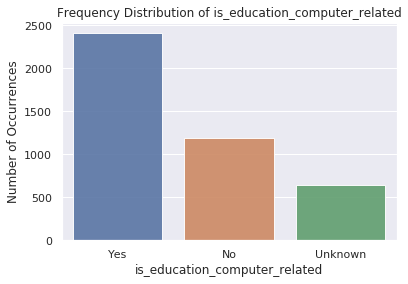

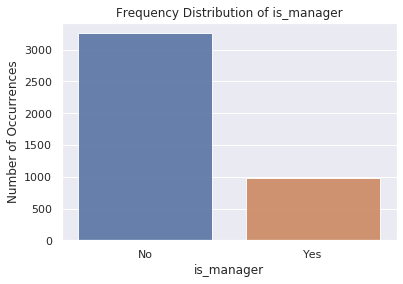

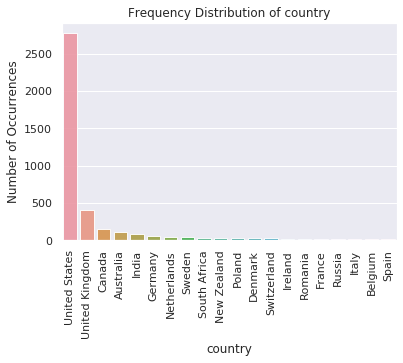

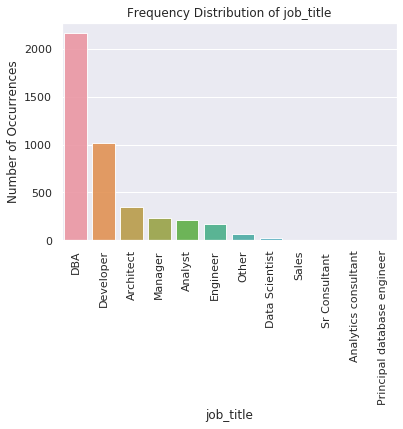

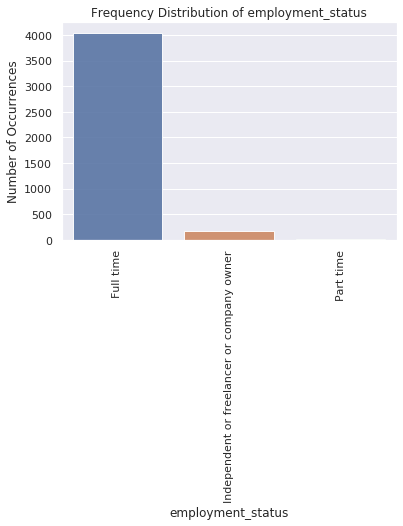

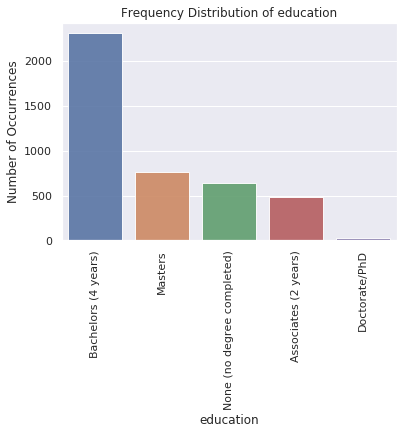

In [1163]:
# all data
continuous=['hours_per_week',
            'telecommute_days_per_week','job_years','salary'
           ]
continuous_rot=[
           ]
continuous_perc=[]
discrete=['certifications',
          'is_education_computer_related',
          'is_manager'          
          ]
discrete_rot=['country', 'job_title','employment_status','education'
          ]

for i in continuous:
    hist_plot(i)
for i in continuous_rot:
    hist_plot_rot(i)
for i in continuous_perc:
    hist_plot_perc(i)
for i in discrete:
    freq_plot(i)
for i in discrete_rot:
    freq_plot_rot(i)

Comments: Most of the observations are for the US country, and for DBA job title.
Most of the variables have a mode. Employment status is mostly Full-time, and most observations have a Bachelors degree in education.
Jobs tend to be computer related.
There is a high incidence of years worked on the job at 5 years. Salaries have a mode around 7,000USD.
Similarly, hours worked per week have a mode at 40 hours per week.
Most of the observations have a 0 number of days working from home (telecommuting).

Let's plot the relation of features against the target variable (salary)

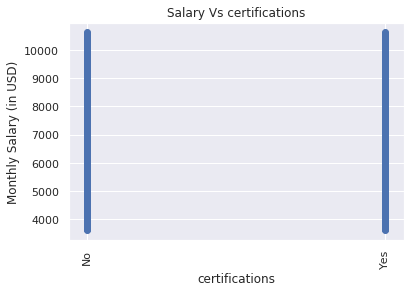

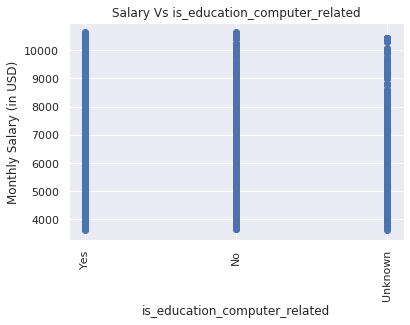

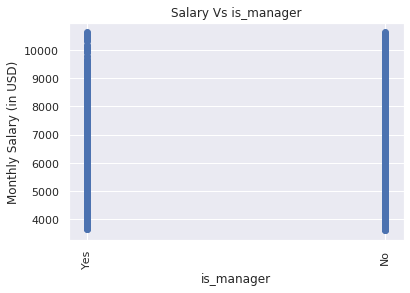

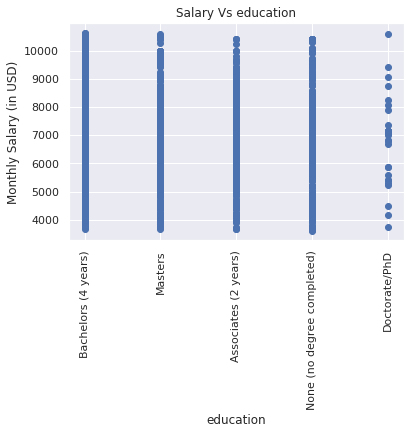

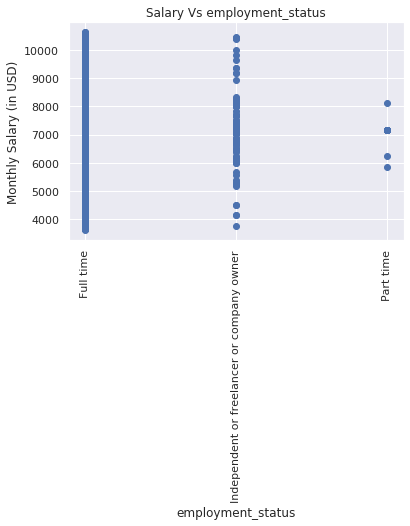

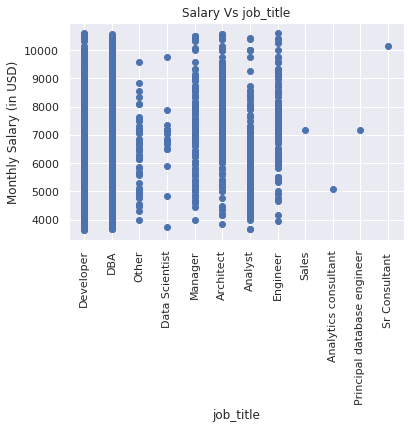

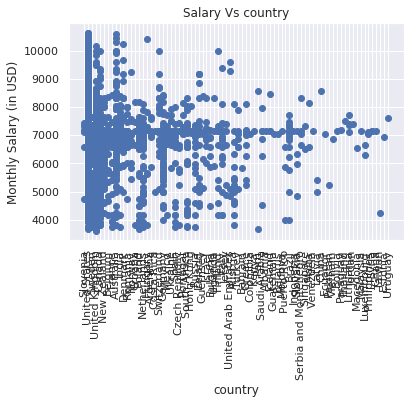

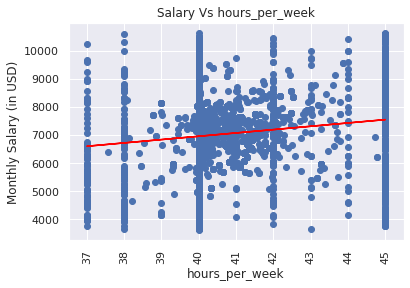

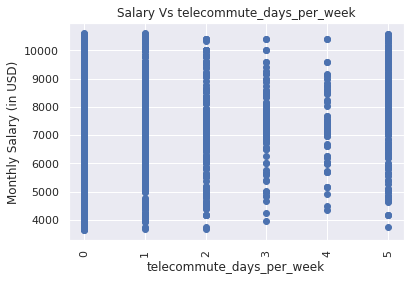

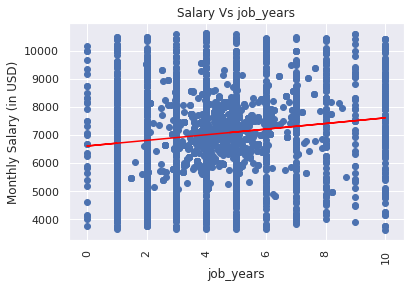

In [1164]:
plt.scatter(data.certifications,data.salary)
plt.title('Salary Vs certifications')
plt.xlabel('certifications')
plt.ylabel('Monthly Salary (in USD)')
plt.xticks(rotation=90)
plt.show()

plt.scatter(data.is_education_computer_related,data.salary)
plt.title('Salary Vs is_education_computer_related')
plt.xlabel('is_education_computer_related')
plt.ylabel('Monthly Salary (in USD)')
plt.xticks(rotation=90)
plt.show()

plt.scatter(data.is_manager,data.salary)
plt.title('Salary Vs is_manager')
plt.xlabel('is_manager')
plt.ylabel('Monthly Salary (in USD)')
plt.xticks(rotation=90)
plt.show()

plt.scatter(data.education,data.salary)
plt.title('Salary Vs education')
plt.xlabel('education')
plt.ylabel('Monthly Salary (in USD)')
plt.xticks(rotation=90)
plt.show()

plt.scatter(data.employment_status,data.salary)
plt.title('Salary Vs employment_status')
plt.xlabel('employment_status')
plt.ylabel('Monthly Salary (in USD)')
plt.xticks(rotation=90)
plt.show()

plt.scatter(data.job_title,data.salary)
plt.title('Salary Vs job_title')
plt.xlabel('job_title')
plt.ylabel('Monthly Salary (in USD)')
plt.xticks(rotation=90)
plt.show()

plt.scatter(data.country,data.salary)
plt.title('Salary Vs country')
plt.xlabel('country')
plt.ylabel('Monthly Salary (in USD)')
plt.xticks(rotation=90)
plt.show()

m, b = np.polyfit(data.hours_per_week, data.salary, 1)
plt.plot(data.hours_per_week, m*data.hours_per_week+b, color='red')
plt.scatter(data.hours_per_week,data.salary)
plt.title('Salary Vs hours_per_week')
plt.xlabel('hours_per_week')
plt.ylabel('Monthly Salary (in USD)')
plt.xticks(rotation=90)
plt.show()

plt.scatter(data.telecommute_days_per_week,data.salary)
plt.title('Salary Vs telecommute_days_per_week')
plt.xlabel('telecommute_days_per_week')
plt.ylabel('Monthly Salary (in USD)')
plt.xticks(rotation=90)
plt.show()

m, b = np.polyfit(data.job_years, data.salary, 1)
plt.plot(data.job_years, m*data.job_years+b, color='red')
plt.scatter(data.job_years,data.salary)
plt.title('Salary Vs job_years')
plt.xlabel('job_years')
plt.ylabel('Monthly Salary (in USD)')
plt.xticks(rotation=90)
plt.show()

Comments: as we can see above, there seems to be little relation between most variable values and salary. 
Yet, number of years at work and hours per week seem to have a positive relation with salary.

Let's prepare the data for estimation with categorical values. In particular, let's create dummy variables for each category of the discrete variables.

In [1165]:
country=pd.get_dummies(data['country'],drop_first=True,dummy_na=False).reset_index(drop=True)
country=country.add_prefix('country_')
employment_status=pd.get_dummies(data['employment_status'],drop_first=True,dummy_na=False).reset_index(drop=True)
employment_status=employment_status.add_prefix('employment_status_')
job_title=pd.get_dummies(data['job_title'],drop_first=True,dummy_na=False).reset_index(drop=True)
job_title=job_title.add_prefix('job_title_')
education=pd.get_dummies(data['education'],drop_first=True,dummy_na=False).reset_index(drop=True)
education=education.add_prefix('education_')
is_education_computer_related=pd.get_dummies(data['is_education_computer_related'],dummy_na=False).reset_index(drop=True)
is_education_computer_related=is_education_computer_related.add_prefix('is_education_computer_related_')
certifications=pd.get_dummies(data['certifications'],drop_first=True,dummy_na=False).reset_index(drop=True)
certifications=certifications.add_prefix('certifications_')
is_manager=pd.get_dummies(data['is_manager'],drop_first=True,dummy_na=False).reset_index(drop=True)
is_manager=is_manager.add_prefix('is_manager_')
data.drop(['country','employment_status','job_title','education','is_education_computer_related','certifications','is_manager'],axis=1,inplace=True)
data=pd.concat([data,country,employment_status,job_title,education,is_education_computer_related,certifications,is_manager], axis=1)

## Visualization, Modeling, Machine Learning

Build a model that can predict  salary and identify how different features influence their decision. Please explain the findings effectively to technical and non-technical audiences using comments and visualizations, if appropriate.
- **Build an optimized model that effectively solves the business problem.**
- **The model will be evaluated on the basis of mean absolute percent error (MAPE).**
- **Read the test.csv file and prepare features for testing.**

In [1166]:
#Loading Test data
test_data=pd.read_csv('test.csv')
test_data.head()

,id,timestamp,country,employment_status,job_title,job_years,is_manager,hours_per_week,telecommute_days_per_week,education,is_education_computer_related,certifications
0,1,12/13/2018 10:23:29,Ukraine,Full time,Developer,5.0,No,40.0,5,Doctorate/PhD,Yes,Yes
1,2,12/21/2017 3:51:48,United Kingdom,Full time,Developer,10.0,Yes,40.0,1,None (no degree completed),Unknown,No
2,3,12/23/2017 12:31:05,United States,Full time,Developer,3.0,No,40.0,0,Associates (2 years),Yes,Yes
3,4,12/14/2017 22:09:43,Canada,Full time,Analyst,5.0,No,40.0,0,Bachelors (4 years),Yes,No
4,5,1/2/2018 13:29:11,United States,Full time,DBA,5.0,Yes,40.0,0,Bachelors (4 years),Yes,No


Let's extract the year from timestamp, since there might be years where salaries are generally different than others.

In [1167]:
test_data['year']=pd.DatetimeIndex(test_data['timestamp']).year
test_data[['timestamp','year']]

,timestamp,year
0,12/13/2018 10:23:29,2018
1,12/21/2017 3:51:48,2017
2,12/23/2017 12:31:05,2017
3,12/14/2017 22:09:43,2017
4,1/2/2018 13:29:11,2018
...,...,...
1065,12/20/2017 8:14:34,2017
1066,12/21/2018 15:46:12,2018
1067,12/12/2017 11:33:04,2017
1068,12/17/2018 8:44:54,2018


We'll drop 'timestamp' from the test data.

In [1168]:
test_data=test_data.drop(columns=['timestamp'])
test_data.columns

Index(['id', 'country', 'employment_status', 'job_title', 'job_years',
       'is_manager', 'hours_per_week', 'telecommute_days_per_week',
       'education', 'is_education_computer_related', 'certifications', 'year'],
      dtype='object')

Now we create dummy variables for categorical values

In [1169]:
country=pd.get_dummies(test_data['country'],drop_first=True,dummy_na=False).reset_index(drop=True)
country=country.add_prefix('country_')
employment_status=pd.get_dummies(test_data['employment_status'],drop_first=True,dummy_na=False).reset_index(drop=True)
employment_status=employment_status.add_prefix('employment_status_')
job_title=pd.get_dummies(test_data['job_title'],drop_first=True,dummy_na=False).reset_index(drop=True)
job_title=job_title.add_prefix('job_title_')
education=pd.get_dummies(test_data['education'],drop_first=True,dummy_na=False).reset_index(drop=True)
education=education.add_prefix('education_')
is_education_computer_related=pd.get_dummies(test_data['is_education_computer_related'],dummy_na=False).reset_index(drop=True)
is_education_computer_related=is_education_computer_related.add_prefix('is_education_computer_related_')
certifications=pd.get_dummies(test_data['certifications'],drop_first=True,dummy_na=False).reset_index(drop=True)
certifications=certifications.add_prefix('certifications_')
is_manager=pd.get_dummies(test_data['is_manager'],drop_first=True,dummy_na=False).reset_index(drop=True)
is_manager=is_manager.add_prefix('is_manager_')
test_data.drop(['country','employment_status','job_title','education','is_education_computer_related','certifications','is_manager'],axis=1,inplace=True)
test_data=pd.concat([test_data,country,employment_status,job_title,education,is_education_computer_related,certifications,is_manager], axis=1)



**The management wants to know the most important features for the model.**

> #### Task:
- **Visualize the top 20 features and their feature importance.**


Let's define the objective function:

In [1170]:
#Defining MAPE function
def MAPE(Y_actual,Y_Predicted):
    mape = np.mean(np.abs((Y_actual - Y_Predicted)/Y_actual))*100
    return mape

Let's define a model

In [1171]:
# define the model
XGBRmodel = XGBRegressor()

Let's fit the model, note that we drop observations where at least one feature data point is missing

In [1172]:
data=data.dropna()
X = data.copy()
X=X.drop(columns=['id','salary'])
y = data["salary"]
X = X.iloc[:,:]
# fit the model
XGBRmodel.fit(X, y)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=2,
             num_parallel_tree=1, objective='reg:squarederror',
             predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

Feature: 0, Score: 0.03355
Feature: 1, Score: 0.02607
Feature: 2, Score: 0.02598
Feature: 3, Score: 0.02304
Feature: 4, Score: 0.02289
Feature: 5, Score: 0.02184
Feature: 6, Score: 0.02128
Feature: 7, Score: 0.02120
Feature: 8, Score: 0.02105
Feature: 9, Score: 0.02093
Feature: 10, Score: 0.02087
Feature: 11, Score: 0.02017
Feature: 12, Score: 0.02000
Feature: 13, Score: 0.01937
Feature: 14, Score: 0.01905
Feature: 15, Score: 0.01880
Feature: 16, Score: 0.01854
Feature: 17, Score: 0.01823
Feature: 18, Score: 0.01823
Feature: 19, Score: 0.01811


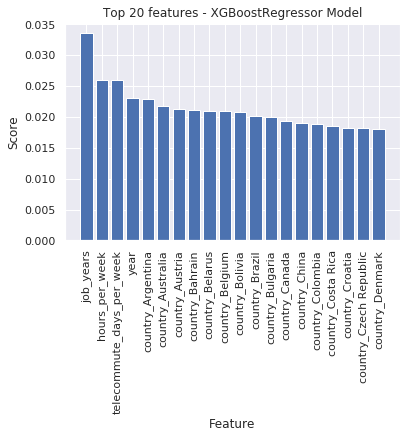

In [1173]:
# get importance
importance=XGBRmodel.feature_importances_
importance=np.sort(importance)[::-1]
importance_idxs=np.argsort(importance)[::-1]
X = data.copy()
X=X.drop(columns=['id','salary'])
features=[X.columns[i] for i in importance_idxs]
# summarize feature importance
for i,v in enumerate(importance[0:20]):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([features[x] for x in range(len(importance[0:20]))],importance[0:20])
pyplot.xticks(rotation=90)
pyplot.ylabel('Score')
pyplot.xlabel('Feature')
pyplot.title('Top 20 features - XGBoostRegressor Model')
pyplot.show()
X_train=X.copy()

Comments: the above findings corroborate what we have seen in our data analysis. 
Both the years on the job and the hours per week variables are important features to explain salary. In fact, they are the top 2 features.
It is also not surprising that countries are important features since salary variation is expected given that regional economic performance in the world is unalike.

XGBoostRegressor Mean Absolute Percent Error

In [1174]:
y_train=XGBRmodel.predict(X)
print(round(MAPE(y,y_train),2))

9.09


I drop these values in the following as the estimation suggests that there is multicollinearity problems (I could show with more time)

In [1175]:
data.drop(['is_education_computer_related_No','is_education_computer_related_Unknown','is_education_computer_related_Yes'],axis=1,inplace=True)

Let us do the similar analysis changing the model to a Linear Regression model.

In [1176]:
# define the model
LRmodel=LinearRegression()
data=data.dropna()
X = data.copy()
X=X.drop(columns=['id','salary'])
y = data["salary"]
X = X.iloc[:,:]
# fit the model
LRmodel.fit(X, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Let's look at feature importance in this model

Feature: 0, Score: 3508.26132
Feature: 1, Score: 3207.07595
Feature: 2, Score: 2781.49579
Feature: 3, Score: 2194.46931
Feature: 4, Score: 2097.15252
Feature: 5, Score: 1994.68649
Feature: 6, Score: 1916.25856
Feature: 7, Score: 1905.75648
Feature: 8, Score: 1734.90460
Feature: 9, Score: 1591.71500
Feature: 10, Score: 1486.40812
Feature: 11, Score: 1415.95476
Feature: 12, Score: 1262.80017
Feature: 13, Score: 1139.41792
Feature: 14, Score: 1025.11634
Feature: 15, Score: 1011.27800
Feature: 16, Score: 963.20078
Feature: 17, Score: 937.44037
Feature: 18, Score: 864.52694
Feature: 19, Score: 810.88964


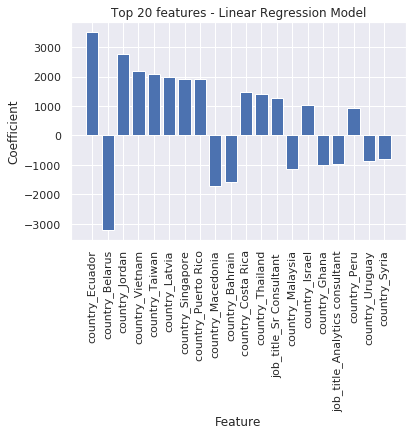

In [1177]:
# get importance
coefficients=LRmodel.coef_
importance=np.sort(abs(coefficients))[::-1]
importance_idxs=np.argsort(abs(coefficients))[::-1]
X = data.copy()
X=X.drop(columns=['id','salary'])
features=[X.columns[i] for i in importance_idxs]
coefficients=[coefficients[i] for i in importance_idxs]
# coefficients
# summarize feature importance
for i,v in enumerate(importance[0:20]):
	print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([features[x] for x in range(len(importance[0:20]))],coefficients[0:20])
pyplot.xticks(rotation=90)
pyplot.ylabel('Coefficient')
pyplot.xlabel('Feature')
pyplot.title('Top 20 features - Linear Regression Model')
pyplot.show()

Comments: The first thing that we note is that feature importace is remarkably different using the XGBoostRegressor Model or the Linear Regression Model. The Linear Regression Model is easier to interpret but more rigid for prediction purposes. The model finds country and job title effects to be the most important features.

Linear Regression Mean Absolute Percentage Error

In [1178]:
y_train=LRmodel.predict(X)
print(round(MAPE(y,y_train),2))

13.8


Comments: Mean absolute percentage error is lower for the XGBoostRegressor Model in the train data (9.09 in XGBoostRegressor Model Vs 13.8 in the Linear Regression Model). Based on this metric, we shall discriminate the two models in favour of the XGBoostRegressor Model.

> #### Task:
- **Submit the predictions on the test dataset using the optimized model** <br/>
    For each record in the test set (`test.csv`), predict the value of the `salary` variable. Submit a CSV file with a header row and one row per test entry. 

The file (`submissions.csv`) should have exactly 2 columns:
   - **id**
   - **salary**

out-of-sample prediction:

In [1179]:
# test_data=test_data.dropna()
X = test_data.copy()
X=X.drop(columns=['id'])
# Get missing columns in the training test
missing_cols = set(X_train.columns) - set(X.columns)
# Add a missing column in test set with default value equal to 0
for c in missing_cols:
    X[c] = 0
# Ensure the order of column in the test set is in the same order than in train set
X = X[X_train.columns]
y_test=XGBRmodel.predict(X)

In [1180]:
test_data['salary']=y_test
submission_df=test_data[['id','salary']]
# submission_df.head()
submission_df.head()

,id,salary
0,1,7764.879883
1,2,8439.267578
2,3,6701.413574
3,4,7056.600586
4,5,6967.364746


In [1181]:
#Submission
submission_df.to_csv('submissions.csv',index=False)

In [1182]:
print("END!")

END!


---